In [1]:
import requests
import pandas as pd
import numpy as np
import datetime as dt
import scipy
import matplotlib.pyplot as plt
from fitter import Fitter, get_common_distributions, get_distributions
from bs4 import BeautifulSoup
from scipy.stats import genhyperbolic

In [2]:
class getData:
    
    def __init__(self):
       pass
    
    def send_request(self,url):
        with requests.session():
            header = {'Connection': 'keep-alive',
                'Expires': '-1',
                'Upgrade-Insecure-Requests': '1',
                'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; WOW64) \
                AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.6099.227 Safari/537.36'
                    }
            
            response = requests.get(url,headers=header)
        return(response)
    
    def get_price(self,url):
        
        view = self.send_request(url)
        price = float(BeautifulSoup(view.content,'html.parser').find(class_="D(ib) Mend(20px)").find_next("fin-streamer").text)
        return(price)
    
    def get_csv(self,date,symbol):
        
        url = "https://query1.finance.yahoo.com/v7/finance/download/{}?period1=631238400&period2={}&interval=1d&events=history&includeAdjustedClose=true".format(symbol,date) 
        response_data = self.send_request(url).text
        data = pd.DataFrame([row.split(",") for row in response_data.split("\n")],columns=response_data.split("\n")[0].split(","))[1:]
        return(data)

In [3]:
date = str(int((dt.datetime.today()).replace(hour=0,minute=0,second=0,microsecond=0).timestamp()))
vix_data = getData().get_csv(date,"^VIX")

In [4]:
def data_clean(df):
    
    df['Date'] = pd.to_datetime(df['Date'])
    df2 = df.loc[:,~df.columns.str.contains('|'.join(["Date","Volume"]))].apply(lambda x: pd.to_numeric(x,errors='coerce'))
    df2.insert(0,"Date",df['Date'])
    df2.dropna(inplace=True)
    df2.reset_index(drop=True,inplace=True)
    return(df2)

vix = data_clean(vix_data)
data = vix['Adj Close'].values

In [5]:
def fit_dist(data,dists):
    f = Fitter(data,distributions=dists)
    f.fit()
    return(f)

In [6]:
dist = fit_dist(data,['genhyperbolic','fatiguelife','invgauss','gamma','beta','lognorm','exponweib','johnsonsb'])

2024-03-20 14:03:21.534 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=0.001603)
2024-03-20 14:03:31.565 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted gamma distribution with error=0.00153)
2024-03-20 14:03:34.869 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted fatiguelife distribution with error=0.001187)
2024-03-20 14:03:36.832 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted invgauss distribution with error=0.001337)
2024-03-20 14:03:40.946 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted genhyperbolic distribution with error=0.00107)
2024-03-20 14:03:41.238 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted johnsonsb distribution with error=0.001345)
2024-03-20 14:03:41.283 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted beta distribution with error=0.001525)
2024-03-20 14:03:41.823 | INFO     | fitter.fitter:_fit_single_distribution:3

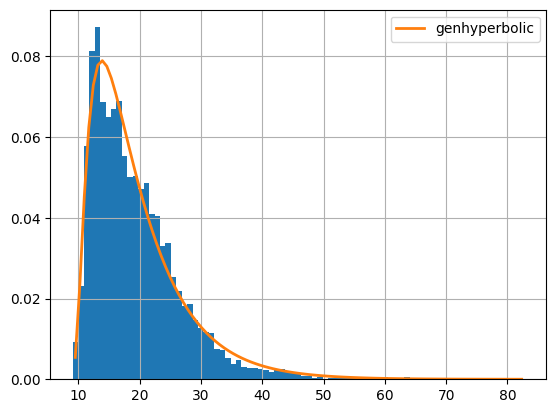

In [7]:
def show_fit(data,dist):
    plt.hist(data,density=True,bins='auto',histtype='stepfilled')
    dist.plot_pdf(names=list(dist.get_best(method = 'sumsquare_error').keys())[0])
    plt.show()

show_fit(data,dist)

In [8]:
best_dist = dist.get_best(method = 'sumsquare_error')
p = best_dist['genhyperbolic']['p']
a = best_dist['genhyperbolic']['a']
b = best_dist['genhyperbolic']['b']
loc = best_dist['genhyperbolic']['loc']
scale = best_dist['genhyperbolic']['scale']

In [9]:
def backtest_strategy(price,percentile,vix,tolerance,window,rollcost,showplt):

    def return_profile(dist_name,show_plt,param,loc,scale):

        return_level, probability = [], []

        for i in range(0,11,1):
            return_level.append(i/10)
            if param != None:
                probability.append(1 - getattr(scipy.stats,dist_name).cdf(i/10,param,loc=loc,scale=scale))
            else:
                probability.append(1 - getattr(scipy.stats,dist_name).cdf(i/10,loc=loc,scale=scale))

        df = pd.DataFrame([probability],columns=return_level)

        def addlabels(x,y):
            for i in range(len(x)):
                plt.text(i/10,y[i],round(y[i],2))

        if show_plt == True:
            plt.plot(return_level,probability)
            addlabels(return_level,probability)
            plt.ylabel("Probability of Return")
            plt.xlabel("Max Period Return")
            plt.gca().set_xticklabels([f'{x:.0%}' for x in plt.gca().get_xticks()]) 
            plt.show()

        return(df)

    def return_dist_build(projected_returns,show_plt):

        dist2 = fit_dist(projected_returns,get_common_distributions())
        return_dist = dist2.get_best(method = 'sumsquare_error')
        dist_name = list(dist2.get_best(method = 'sumsquare_error').keys())[0]

        if show_plt == True:
            show_fit(projected_returns,dist2)

        for name in get_common_distributions():
            if name == dist_name:
                shape = getattr(scipy.stats,name).shapes
                if shape != None:
                    param = return_dist[dist_name][shape]
                    return_loc = return_dist[dist_name]['loc']
                    return_scale = return_dist[dist_name]['scale']
                else: 
                    return_loc = return_dist[dist_name]['loc']
                    return_scale = return_dist[dist_name]['scale']
                    param = None

        df = return_profile(dist_name,show_plt,param,return_loc,return_scale)
        return(df,dist_name)

    backtest = vix.copy()
    backtest = backtest[["Date","Adj Close"]]
    backtest['Percentile'] = backtest['Adj Close'].apply(lambda x: genhyperbolic.cdf(x,p,a,b,loc=loc,scale=scale))
    backtest['Forward Max Gain'] = (backtest['Adj Close'].rolling(window).max().shift(-window) - backtest['Adj Close'] - rollcost) / backtest['Adj Close']
    backtest.dropna(inplace=True)

    near_price = backtest.copy()
    near_price = near_price[(near_price['Percentile'] < percentile + tolerance) & (near_price['Percentile'] > percentile - tolerance)]
    projected_returns = near_price['Forward Max Gain'].values
    df,dist_name = return_dist_build(projected_returns,showplt)
    df.insert(0,"Dist Used",dist_name)
    df.insert(0,"Price",price)
    return(df)

In [10]:
tolerance  = 0.01
days_ahead = 8
rollcost = 0
showplt = True

In [11]:
# test_price = 12
# test_df = pd.DataFrame()

# while test_price < 25:
#     test_percentile = genhyperbolic.cdf(test_price,p,a,b,loc=loc,scale=scale)
#     df = backtest_strategy(test_price,test_percentile,vix,tolerance,days_ahead,rollcost,showplt)
#     if test_df.empty:
#         test_df = df
#     else: 
#         test_df = pd.concat([test_df,df])
    
#     test_price += 0.5 

# test_df

In [12]:
price = getData().get_price("https://ca.finance.yahoo.com/quote/%5EVIX?p=%5EVIX")
percentile = genhyperbolic.cdf(price,p,a,b,loc=loc,scale=scale)
price

13.09

2024-03-20 14:03:56.055 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=60.341255)
2024-03-20 14:03:56.074 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted uniform distribution with error=134.823208)
2024-03-20 14:03:56.104 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expon distribution with error=76.879574)
2024-03-20 14:03:56.114 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted cauchy distribution with error=22.103887)
2024-03-20 14:03:56.136 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted powerlaw distribution with error=120.949883)
2024-03-20 14:03:56.138 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted rayleigh distribution with error=45.859771)
2024-03-20 14:03:56.147 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted gamma distribution with error=25.882803)
2024-03-20 14:03:56.298 | INFO     | fitter.fitter:_fit_single_distribution:337 

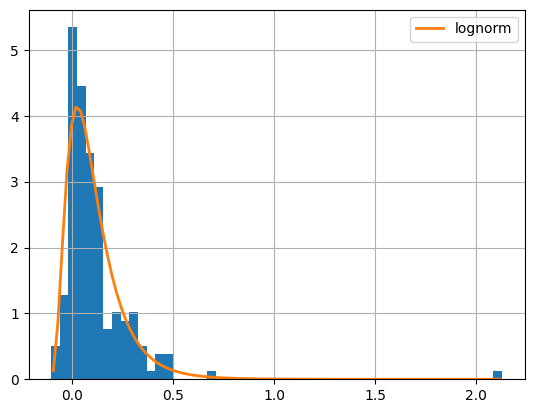

C:\Users\steve\AppData\Local\Temp\ipykernel_27004\1983520853.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels([f'{x:.0%}' for x in plt.gca().get_xticks()])


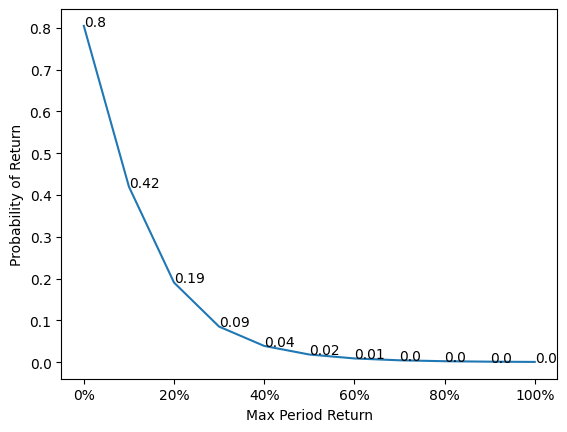

In [13]:
df = backtest_strategy(price,percentile,vix,tolerance,days_ahead,rollcost,showplt)

In [283]:
def return_profile(dist_name,show_plt,param,loc,scale):

    return_level, probability = [], []

    for i in range(0,11,1):
        return_level.append(i/10)
        if scale != None:
            probability.append(1 - getattr(scipy.stats,dist_name).cdf(i/10,param,loc=loc,scale=scale))
        else:
            probability.append(1 - getattr(scipy.stats,dist_name).cdf(i/10,loc=loc,scale=scale))

    def addlabels(x,y):
        for i in range(len(x)):
            plt.text(i/10,y[i],round(y[i],2))

    if show_plt == True:
        plt.plot(return_level,probability)
        addlabels(return_level,probability)
        plt.ylabel("Probability of Return")
        plt.xlabel("Return")
        plt.show()


In [285]:
def return_dist_build(projected_returns):

    dist2 = fit_dist(projected_returns,get_common_distributions())
    return_dist = dist2.get_best(method = 'sumsquare_error')
    dist_name = list(dist2.get_best(method = 'sumsquare_error').keys())[0]

    show_fit(projected_returns,dist2)

    for name in get_common_distributions():
        if name == dist_name:
            shape = getattr(scipy.stats,name).shapes
            if shape != None:
                param = return_dist[dist_name][shape]
                return_loc = return_dist[dist_name]['loc']
                return_scale = return_dist[dist_name]['scale']
            else: 
                return_loc = return_dist[dist_name]['loc']
                return_scale = return_dist[dist_name]['scale']

    return_profile(dist_name,True,param,return_loc,return_scale)

2024-01-28 15:30:57.562 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expon distribution with error=8.89787)
2024-01-28 15:30:57.586 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted powerlaw distribution with error=16.409028)
2024-01-28 15:30:57.595 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted rayleigh distribution with error=6.573815)
2024-01-28 15:30:57.602 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=8.514199)
2024-01-28 15:30:57.610 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted uniform distribution with error=19.56166)
2024-01-28 15:30:57.627 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted cauchy distribution with error=5.767)
2024-01-28 15:30:57.781 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted chi2 distribution with error=13.138908)
2024-01-28 15:30:57.826 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted log

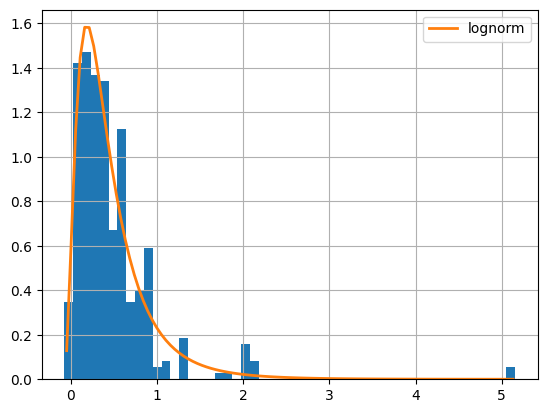

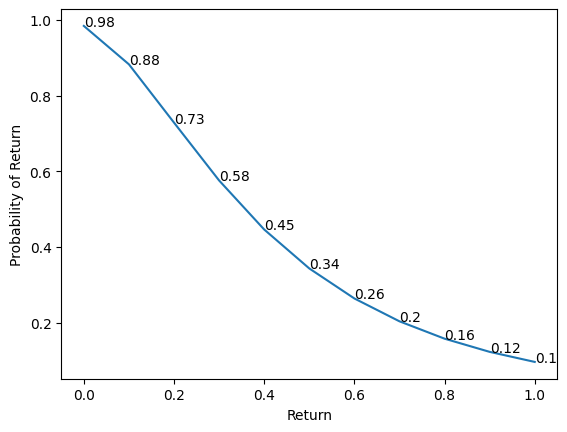

In [320]:
backtest = vix.copy()
backtest = backtest[["Date","Adj Close"]]
backtest['Percentile'] = backtest['Adj Close'].apply(lambda x: genhyperbolic.cdf(x,p,a,b,loc=loc,scale=scale))
backtest['Forward Max Gain'] = (backtest['Adj Close'].rolling(window).max().shift(-window) - backtest['Adj Close']) / backtest['Adj Close']
backtest.dropna(inplace=True)

near_price = backtest.copy()
near_price = near_price[(near_price['Percentile'] < percentile + tolerance) & (near_price['Percentile'] > percentile - tolerance)]
projected_returns = near_price['Forward Max Gain'].values
return_dist_build(projected_returns)